# Part 3  - Predictive Modeling



In [2]:
%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
from  datetime import timedelta as td
import pandas as pd
import numpy as np
import json
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm
from sklearn.preprocessing import robust_scale
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

/Users/michaelweilMichael/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Loading the Data

In [3]:
json_request=open('uber_data_challenge.json')
json_data = json.load(json_request)
data=pd.DataFrame(json_data)
json_request.close()

First look of the data : 

In [4]:
data.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


We already notice some missing values regarding the average rating given by the user. However, this gives a lot of information about user churn. 

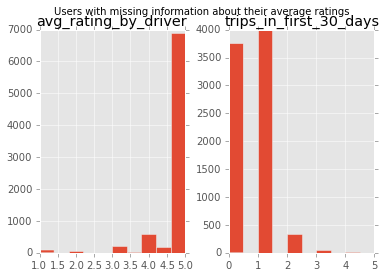

In [5]:
plt.figure()
histo=data[data.avg_rating_of_driver.isnull()][['avg_rating_by_driver','trips_in_first_30_days']].hist()
plt.suptitle('Users with missing information about their average ratings')

Based on the histogram of the trips in the first 30 days, information might be missing because the riders did not use the app very often.

Looking at the distribution of the ratings received by users with missing information, we notice a few amount of very low ratings (1.0, 2.0). These extreme cases are relevant to our problem of predicting user retention. For instance, a new user might have a very bad experience with the driver during his/her first ride, thus leading to never use the app again. 

A missing value regarding the average rating by the user can be a good indicator of customer churn. Therefore we decide not to remove the rows but to replace these 'NaN' values by '0'.

In [216]:
data.loc[data.avg_rating_of_driver.isnull(),"avg_rating_of_driver"]=0.0

Some values about the average rating given by the driver are missing. We decide to perform the same transformation as above.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113f5cf98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1168f7a90>]], dtype=object)

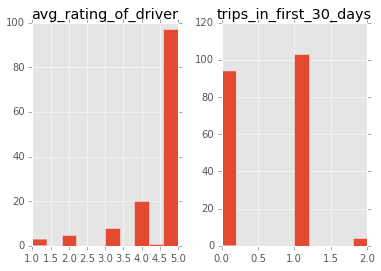

In [6]:
data[data.avg_rating_by_driver.isnull()][['avg_rating_of_driver','trips_in_first_30_days']].hist()

In [218]:
data.loc[data.avg_rating_by_driver.isnull(),"avg_rating_by_driver"]=0.0

## Distribution of the Covariates

/Users/michaelweilMichael/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  app.launch_new_instance()
/Users/michaelweilMichael/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Users/michaelweilMichael/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


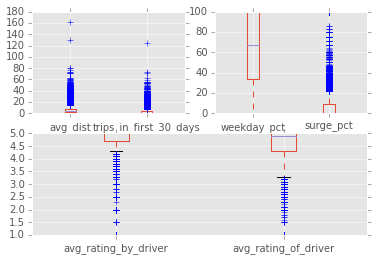

In [7]:
plt.figure()
plt.subplot(2,2 , 1)
bp1=data.boxplot(column=['avg_dist','trips_in_first_30_days'])
plt.subplot(2, 2, 2)
bp2=data.boxplot(column=['weekday_pct','surge_pct'])
plt.subplot(2, 1, 2)
bp3=data.boxplot(column=['avg_rating_by_driver','avg_rating_of_driver'])


The boxplots above show a lot of outliers. Removing the outliers -for instance by keeping the rows in $[Q_1-1.5\cdot\text{IQR},Q_3+1.5\cdot \text{IQR}]$, will eliminate a high amount of data. Besides, customer retention on outliers is a problem we want to understand. For example, a very high surge percentage can possibly be viewed as a "bad experience" that drives away customers.

Then outliers are relevant, we decide to keep them.


## Retention

A user is retained when he or she is “active” in the preceding 30 days.
The most recent last trip date is July 1st 2014.


In [8]:
data[['signup_date','last_trip_date']]=data[['signup_date','last_trip_date']].apply(pd.to_datetime)

latest_date=max(data.last_trip_date)
print(latest_date)


2014-07-01 00:00:00


Then, an active user has his or her last trip 30 days or less before July 1st 2014.

In [9]:
data['retained']=(max(data.last_trip_date)-data.last_trip_date)
data['retained']=data['retained']<=td(days=30)
data['inactive']=~data['retained']

## Retention rate

About 37.6 % of the users were retained. 

In [10]:
data.retained.mean()

0.37608000000000003

## Cities

The data operate in three different cities : Winterfell, King's Landing and Astapor. Each city means a different marketplace with possible insights.

In [11]:
city=data.groupby('city')

The statistics of the factors in terms of mean are relatively the same for the three cities. Winterfell users however have a lower surge percentage.

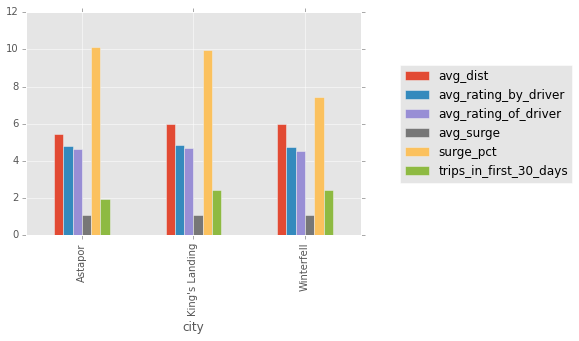

In [12]:
ax=city.mean().drop(['retained','inactive','uber_black_user','weekday_pct'],axis=1).plot(kind='bar')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center right', bbox_to_anchor=(1.65,0.5))

But after looking at the number of retained/inactive users, it seems that King's Landing has more active users than inactive ones. On the contrary, Astapor faces a high ratio of inactive users.

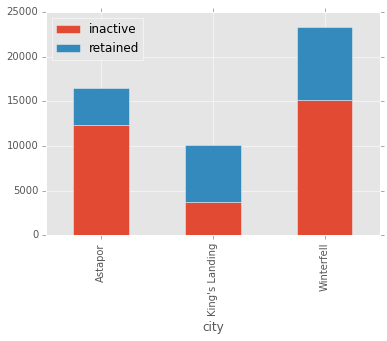

In [13]:
city.sum()[['inactive','retained']].plot(kind='bar',stacked=True)

## Phone

Uber can be installed on  Iphone or  Android. Each OS has slightly different versions of the app, however retention can be explained by this difference, for instance, one version can be slower or less user-friendly than the other. 


In [14]:
phone=data.groupby('phone')

Again, the metrics are on average the same for iPhone and Android.

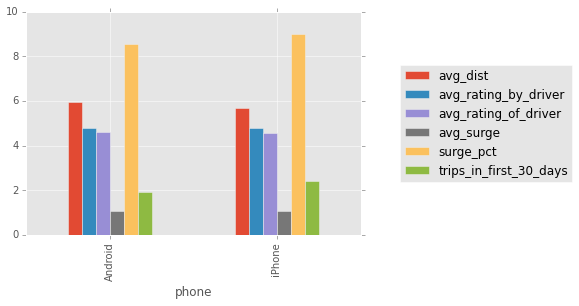

In [15]:
ax2=phone.mean().drop(['retained','inactive','uber_black_user','weekday_pct'],axis=1).plot(kind='bar')
handles2, labels2 = ax2.get_legend_handles_labels()
lgd2 = ax2.legend(handles2, labels2, loc='center right', bbox_to_anchor=(1.65,0.5))

In terms of user retention, we actually observe a high inactive rate for Android users. As mentionned above, this can be due to an issue related to the design of the Android app.

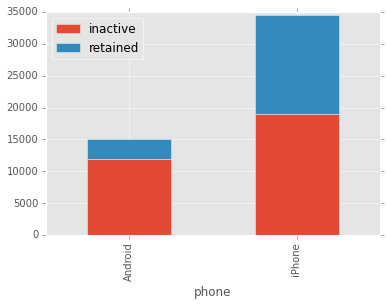

In [229]:
phone.sum()[['inactive','retained']].plot(kind='bar',stacked=True)

## Correlation between covariates


The ratings by and of the driver are highly correlated, probably because the user and the drivers share the same experience. Obviously, surge percentage and average surge are strongly correlated.

There seems to be a correlation between ever using Uber Black during the first 30 days and retention.



In [38]:
data.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,retained,inactive
avg_dist,1.000000,0.069888,0.019367,-0.073912,-0.076056,-0.053858,0.030138,0.061672,-0.005475,0.005475
avg_rating_by_driver,0.069888,1.000000,0.171188,-0.175682,-0.155399,-0.239427,-0.056930,0.000915,-0.242463,0.242463
avg_rating_of_driver,0.019367,0.171188,1.000000,-0.069685,-0.055247,-0.120590,-0.020892,-0.002232,-0.083998,0.083998
avg_surge,-0.073912,-0.175682,-0.069685,1.000000,0.879619,0.236306,0.050749,-0.036151,0.281272,-0.281272
surge_pct,-0.076056,-0.155399,-0.055247,0.879619,1.000000,0.214935,0.034942,-0.042047,0.262852,-0.262852
trips_in_first_30_days,-0.053858,-0.239427,-0.120590,0.236306,0.214935,1.000000,0.059717,0.014627,0.149852,-0.149852
uber_black_user,0.030138,-0.056930,-0.020892,0.050749,0.034942,0.059717,1.000000,0.008396,0.192303,-0.192303
weekday_pct,0.061672,0.000915,-0.002232,-0.036151,-0.042047,0.014627,0.008396,1.000000,0.005131,-0.005131
retained,-0.005475,-0.242463,-0.083998,0.281272,0.262852,0.149852,0.192303,0.005131,1.000000,-1.000000
inactive,0.005475,0.242463,0.083998,-0.281272,-0.262852,-0.149852,-0.192303,-0.005131,-1.000000,1.000000


# Predictive Model

In our approach, the only variables that are not taken into account in our model are the dates.


In [17]:
y,X=dmatrices('retained ~uber_black_user+trips_in_first_30_days+surge_pct+avg_surge+city+phone+avg_dist+weekday_pct+avg_rating_by_driver+avg_rating_of_driver',data,return_type="dataframe")
y = y['retained[True]']

## Simple Logistic Regression


The idea is to estimate the probability of retention. We will first fit  a logistic regression model to all the data, and try to understand the impact of each factors.

In [46]:
LR=sm.Logit(y,X)
results=LR.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.570736
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         retained[True]   No. Observations:                41445
Model:                          Logit   Df Residuals:                    41433
Method:                           MLE   Df Model:                           11
Date:                Thu, 25 Aug 2016   Pseudo R-squ.:                  0.1572
Time:                        10:24:34   Log-Likelihood:                -23654.
converged:                       True   LL-Null:                       -28068.
                                        LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  -0.7188      0.180     -3.985      0.000        -1.072    -0.365
uber_black_user[T.True]     0.9128      0.023     39.505      0.000         0.867     0.958
city[T.King's Landing]      1.7008      0.032     52.886      0.000         1.638     1.764
city[T.Winterfell]          0.5341      0.026     20.310      0.000         0.483     0.586
phone[T.iPhone]             1.1043      0.026     41.697      0.000         1.052     1.156
trips_in_first_30_days      0.1041      0.003     29.866      0.000         0.097     0.111
surge_pct                   0.0043      0.001      4.137      0.000         0.002     0.006
avg_surge                  -0.2534      0.097     -2.611      0.009        -0.444    -0.063
avg_dist                   -0.0381      0.002    -15.665      0.000        -0.043    -0.033
weekday_pct                -0.0001      0.000     -0.431      0.666        -0.001     0.001
avg_rating_by_driver       -0.2176      0.027     -7.982      0.000        -0.271    -0.164
avg_rating_of_driver       -0.0491      0.018     -2.697      0.007        -0.085    -0.013
===========================================================================================
"""

We notice that, at a 0.05 significance level, the variable "weekday_pct" is statistically insignificant with the logistic regression model.

Again, we see that King's Landing has an impact on retention with a log-odd increase of 1.70. 

We also notice that the "iPhone factor" drives retention. Moreover, having used a uber black during the first 30 days is a good predictor for retention.

## Log Regression + Elastic Net


We saw before that some of the predictors are highly correlated. A possible solution to this problem is to penalize the logistic regression.

We will apply a Elastic Net regularization, which linearly combines Ridge Regression (L2 penalty) and Lasso (L1 penalty) : $$ L = \alpha\cdot\rho||\beta||_1+\frac{\alpha\cdot(1-\rho)}{2}||\beta||_2^2   $$
$\beta$ is the vector of coefficients + offset, $\alpha$ is the Elastic Net penalty coefficient, $\rho$ is the L1 ratio.

To have regularization, the data need to be scaled. However, the data contain many outliers, scaling using the mean and variance is likely to not work very well. The alternative is to use the "robust_scale" function, which centers to the median and component wise scales according to the interquartile range.

After scaling, we split the data into a train set (70% of th dataset) and a test set.

In [37]:
X_norm = robust_scale(X)
X_train,X_test,y_train,y_test = train_test_split(X_norm,y
                                                 ,test_size = 0.3
                                                 ,random_state=6)

The log regression with elastic net will be trained using a stochastic gradient descent. The parameters $\alpha, \rho$ are set after a grid search measuring the score of a 10-fold cross-validation.

In [38]:
parameters = {
    'random_state' : [0],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001],
    'l1_ratio' : [0,0.1,0.25,0.5,0.75,0.9,1],
}
grid_search = GridSearchCV(SGDClassifier(penalty='elasticnet',loss='log'),
                           parameters,cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'random_state': [0], 'alpha': [0.001, 0.0001, 1e-05, 1e-06], 'l1_ratio': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [45]:
best_parameters = grid_search.best_estimator_.get_params()
print(best_parameters)
print(grid_search.best_score_)

{'average': False, 'l1_ratio': 0.5, 'verbose': 0, 'n_jobs': 1, 'loss': 'log', 'epsilon': 0.1, 'eta0': 0.0, 'power_t': 0.5, 'learning_rate': 'optimal', 'class_weight': None, 'random_state': 0, 'warm_start': False, 'alpha': 0.001, 'n_iter': 5, 'shuffle': True, 'fit_intercept': True, 'penalty': 'elasticnet'}
0.700630795216


The best parameters are $\alpha = 0.001$ and $\rho = 0.5$. The mean accuracy of the 10-fold cross-validation for the best model is about 70%.

The coefficients are displayed below.

In [47]:
elastic = SGDClassifier(**best_parameters)
elastic.fit(X_train,y_train)
y_pred = grid_search.predict(X_test)

pd.DataFrame(elastic.coef_,columns=X.columns)

,Intercept,uber_black_user[T.True],city[T.King's Landing],city[T.Winterfell],phone[T.iPhone],trips_in_first_30_days,surge_pct,avg_surge,avg_dist,weekday_pct,avg_rating_by_driver,avg_rating_of_driver
0,0.0,0.876283,1.696137,0.607665,1.037232,0.334555,0.0,-0.02024,-0.172961,0.0,-0.063691,0.0


The coefficients of the log-regression still prove the impact of the King's Landing, Uber Black and Iphone factors. 

The odds that a user from King's Landing  is active are marginally $e^{1.6961} \approx 545\%$ of the odds that a user from Astapor is retained. 

Surprisingly, the factors related to surge do not truly impact on retention. Average distance also drives away users. This can be explained by cases where users experienced unoptimized itineraries.

We also notice that the coefficient for average surge, weekday percentage and average rating are equal to 0. The Lasso component indeed encourages sparse estimates and removes components that are highly correlated to others. Lasso can be used for feature selection.

## Model performance


We can evaluate our model on the test set. Below are reported the condusion matrix, the precision/recall and F1 scores. 

The error rate is 29%.

In [48]:
print(confusion_matrix(y_pred,y_test))
print (classification_report(y_pred,y_test ,digits=3))
print(np.mean(abs(y_pred-y_test)))

[[6006 2304]
 [1352 2772]]
             precision    recall  f1-score   support

        0.0      0.816     0.723     0.767      8310
        1.0      0.546     0.672     0.603      4124

avg / total      0.727     0.706     0.712     12434

0.29403249155541256


## Alternatives considered


Another way to estimate the probability of retention is to use Neural Networks. A good solution would be a MultiLayer  Perceptron (MLP) with a softmax activation function for the output. The softmax output can indeed be considered as a probability distribution over a finite set of outcomes.

The perfomance of the MLP model would be compared with the performance of the Log Regression + Elastic Net. 

However, the MLP function on scikit learn is not available yet and there are no python packages with built-in MLP.

# Insights


Based on our model, we see that King’s Landing is a good market for Uber whereas Astapor is not. 

Another good insight is the type of phone. The odds of being active for a iPhone user is marginally $e^{1.04}-1\approx183\%$ more than the odds for a Android user. Therefore Uber needs to investigate on the Android user experience, and try  to modify the design of the Android app to make it more attractive.


The factor uber_black_user is also a good predictor for retention.
Then a good initiative for Uber would be to offer new users a free ride on Uber Black.

The average rating of the driver is also an indictor of retention. Suprisingly, the average distance negatively impacts on being active. Theses two predictors emphasize the quality of the ride as a key factor. Users are taking Uber to have a pleasant and efficient ride. Extreme cases of bad experience with a driver or an itinerary longer than usual will drive away users. Another interesting metrics to consider  would have been the average time of a ride and the average ETA.
To avoid bad ride experience making the user quit the app, Uber needs to enable communication through a detailed feedback.




